In [1]:
import os
import rawpy
import numpy as np
import math
import seaborn as sns
import cv2
import sys
import matplotlib.pyplot as plt
import pickle
import time
from IPython.display import clear_output
from skimage.util import random_noise

In [2]:
NUM_IMAGES = 200

## IMPORT IMAGES

In [3]:
def get_images():
    file = open('./dataset/Sony_train_list.txt').read()
    pairs = file.split('\n')
    np.random.shuffle(pairs)
    pairs = pairs[:NUM_IMAGES]
    
    image_paths = dict()
    image_paths['dark'] = []
    image_paths['bright'] = []
    
    images = dict()
    images['dark'] = []
    images['bright'] = []
    
    start_time = time.time()
    for idx, pair in enumerate(pairs):
        dark_path = pair.split()[0]
        dark_image = rawpy.imread('./dataset/'+dark_path).postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=8)
        dark_image = cv2.cvtColor(dark_image, cv2.COLOR_RGB2BGR)
        image_paths['dark'].append(dark_path)
        images['dark'].append(dark_image)
        
        bright_path = pair.split()[1]
        bright_image = rawpy.imread('./dataset/'+bright_path).postprocess(use_camera_wb=True, output_bps=8)
        bright_image = cv2.cvtColor(bright_image, cv2.COLOR_RGB2BGR)
        image_paths['bright'].append(bright_path)
        images['bright'].append(bright_image)
        
        print('Image Set: {}/{} \t {} \t {}'.format(idx+1, NUM_IMAGES, dark_path, bright_path))
    
    with open('./images.pickle', 'wb') as handle:
        pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('./image_paths.pickle', 'wb') as handle:
        pickle.dump(image_paths, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    elapsed_time = time.time() - start_time
    print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))
    
    return image_paths, images

In [4]:
# Comment out the next line if you want to use pickle files
# image_paths, images = get_images()

In [5]:
with open('image_paths.pickle', 'rb') as handle:
    image_paths = pickle.load(handle)

In [6]:
with open('images.pickle', 'rb') as handle:
    images = pickle.load(handle)

## BLACK LEVEL

In [7]:
black_levels = []

start_time = time.time()
for idx, (bright, dark) in enumerate(zip(images['bright'], images['dark'])):
    sub = np.subtract(bright, dark)
    avg_sub = np.average(sub)
    black_levels.append(avg_sub)
    
    print('Image Set {} \t Black Level: {:.2f}'.format(idx+1, avg_sub))

elapsed_time = time.time() - start_time
print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))

Image Set 1 	 Black Level: 63.85
Image Set 2 	 Black Level: 66.25
Image Set 3 	 Black Level: 126.01
Image Set 4 	 Black Level: 63.12
Image Set 5 	 Black Level: 59.57
Image Set 6 	 Black Level: 63.12
Image Set 7 	 Black Level: 73.79
Image Set 8 	 Black Level: 70.41
Image Set 9 	 Black Level: 55.98
Image Set 10 	 Black Level: 68.77
Image Set 11 	 Black Level: 58.61
Image Set 12 	 Black Level: 108.43
Image Set 13 	 Black Level: 39.54
Image Set 14 	 Black Level: 90.81
Image Set 15 	 Black Level: 77.95
Image Set 16 	 Black Level: 115.98
Image Set 17 	 Black Level: 63.00
Image Set 18 	 Black Level: 73.79
Image Set 19 	 Black Level: 47.24
Image Set 20 	 Black Level: 49.29
Image Set 21 	 Black Level: 82.53
Image Set 22 	 Black Level: 101.21
Image Set 23 	 Black Level: 90.82
Image Set 24 	 Black Level: 90.46
Image Set 25 	 Black Level: 27.60
Image Set 26 	 Black Level: 63.85
Image Set 27 	 Black Level: 107.70
Image Set 28 	 Black Level: 156.98
Image Set 29 	 Black Level: 84.99
Image Set 30 	 Bl

Text(0.5,0,'Black Level')

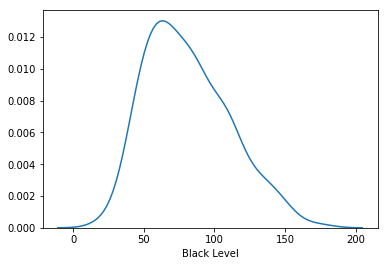

In [8]:
sns.distplot(black_levels, hist=False)
plt.xlabel('Black Level')

In [9]:
print("Black Levels Mean: {:.2f}".format(np.mean(black_levels)))
print("Black Levels Std: {:.2f}".format(np.std(black_levels)))

Black Levels Mean: 81.16
Black Levels Std: 29.39


In [10]:
def apply_black_level(img, bl):
    bl_image = np.copy(img)
    bl_image[bl_image<bl] = int(bl)
    bl_image = bl_image - int(bl)
    
    return bl_image

## COLOR CORRECTION

In [11]:
def apply_color_distortion(img, multipliers):
    img[:, :, 0] = img[:, :, 0]*multipliers['blue'] 
    img[:, :, 1] = img[:, :, 1]*multipliers['green']
    img[:, :, 2] = img[:, :, 2]*multipliers['red']
    
    return img

In [12]:
distortions = []

start_time = time.time()
for idx, (bright, dark, bl) in enumerate(zip(images['bright'], \
                                                    images['dark'], black_levels)):
    
    bright = apply_black_level(bright, bl)
    
    ratio_matrix = np.divide(dark, bright, out=np.zeros_like(dark, dtype=np.float32), where=bright!=0)
    if not np.any(dark[:, :, 0]>10):
        blue = 0.0
    else:
        blue = np.average(ratio_matrix[:, :, 0][dark[:, :, 0]>10])
    
    if not np.any(dark[:, :, 1]>10):
        green = 0.0
    else:
        green = np.average(ratio_matrix[:, :, 1][dark[:, :, 1]>10])
    
    if not np.any(dark[:, :, 2]>10):
        red = 0.0
    else:
        red = np.average(ratio_matrix[:, :, 2][dark[:, :, 2]>10])

    
    distortions.append({'blue': blue, 'green': green, 'red': red})
    
    print('Image Set {} \t Blue: {:.2f}   Green: {:.2f}   Red: {:.2f}'.format(idx+1, blue, green, red))

elapsed_time = time.time() - start_time
print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))

Image Set 1 	 Blue: 0.12   Green: 0.10   Red: 0.13
Image Set 2 	 Blue: 0.13   Green: 0.13   Red: 0.12
Image Set 3 	 Blue: 0.10   Green: 0.09   Red: 0.09
Image Set 4 	 Blue: 0.16   Green: 0.13   Red: 0.11
Image Set 5 	 Blue: 0.34   Green: 0.35   Red: 0.34
Image Set 6 	 Blue: 0.16   Green: 0.13   Red: 0.12
Image Set 7 	 Blue: 0.00   Green: 0.00   Red: 0.00
Image Set 8 	 Blue: 0.11   Green: 0.10   Red: 0.15
Image Set 9 	 Blue: 0.31   Green: 0.43   Red: 0.51
Image Set 10 	 Blue: 0.20   Green: 0.33   Red: 0.09
Image Set 11 	 Blue: 0.13   Green: 0.14   Red: 0.22
Image Set 12 	 Blue: 0.00   Green: 0.00   Red: 0.08
Image Set 13 	 Blue: 0.45   Green: 0.41   Red: 0.38
Image Set 14 	 Blue: 0.20   Green: 0.19   Red: 0.22
Image Set 15 	 Blue: 0.20   Green: 0.17   Red: 0.17
Image Set 16 	 Blue: 0.41   Green: 0.31   Red: 0.48
Image Set 17 	 Blue: 0.63   Green: 0.31   Red: 0.29
Image Set 18 	 Blue: 0.00   Green: 0.00   Red: 0.00
Image Set 19 	 Blue: 0.63   Green: 0.49   Red: 0.10
Image Set 20 	 Blue: 

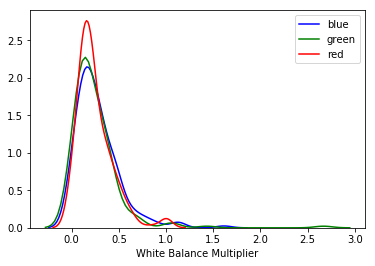

In [13]:
sns.distplot([dist['blue'] for dist in distortions], color='blue', label='blue', hist=False)
sns.distplot([dist['green'] for dist in distortions], color='green', label='green', hist=False)
sns.distplot([dist['red'] for dist in distortions], color='red', label='red', hist=False)
plt.xlabel('White Balance Multiplier')
plt.legend()

In [14]:
print("Blue Distortion Mean: {:.2f}".format(np.mean([dist['blue'] for dist in distortions])))
print("Blue Distortion Std: {:.2f}".format(np.std([dist['blue'] for dist in distortions])))
print()

print("Green Distortion Mean: {:.2f}".format(np.mean([dist['green'] for dist in distortions])))
print("Green Distortion Std: {:.2f}".format(np.std([dist['green'] for dist in distortions])))
print()

print("Red Distortion Mean: {:.2f}".format(np.mean([dist['red'] for dist in distortions])))
print("Red Distortion Std: {:.2f}".format(np.std([dist['red'] for dist in distortions])))

Blue Distortion Mean: 0.27
Blue Distortion Std: 0.23

Green Distortion Mean: 0.24
Green Distortion Std: 0.27

Red Distortion Mean: 0.24
Red Distortion Std: 0.19


## GAMMA (METHOD 1 - Element Wise Log)

In [15]:
unweighted_image_gammas = []
weighted_d_image_gammas = []
weighted_b_image_gammas = []

start_time = time.time()
for idx, (bright, dark, bl, dist) in enumerate(zip(images['bright'], images['dark'], black_levels, distortions)):
    print('Image Set {}'.format(idx+1), end='\t')
    
    bright = apply_black_level(bright, bl)
    bright = apply_color_distortion(bright, dist)
    
    bright_lower = np.where(bright.flatten()<5)[0]
    bright_upper = np.where(bright.flatten()>200)[0]
    dark_lower = np.where(dark.flatten()<5)[0]
    dark_upper = np.where(dark.flatten()>200)[0]
    bad_indices = list(set().union(bright_lower, bright_upper, dark_lower, dark_upper))
    
    filtered_bright = np.delete(bright.flatten(), bad_indices)
#     print(len(filtered_bright))
    log_bright = np.log(filtered_bright, dtype=np.float32)
    
    filtered_dark = np.delete(dark.flatten(), bad_indices)
#     print(len(filtered_dark))
    log_dark = np.log(filtered_dark, dtype=np.float32)
    
    log_array = np.divide(log_dark, log_bright, out=np.zeros_like(log_dark, dtype=np.float32), where=log_bright!=0)
    
    unweighted_gamma = np.average(log_array)
    unweighted_image_gammas.append(unweighted_gamma)
    
#     weighted_d_gamma = np.average(log_array, weights=filtered_dark)
#     weighted_d_image_gammas.append(weighted_d_gamma)
    
#     weighted_b_gamma = np.average(log_array, weights=filtered_bright)
#     weighted_b_image_gammas.append(weighted_b_gamma)
    
    print('Unweighted Gamma: {:.2f}'.format(unweighted_gamma))

elapsed_time = time.time() - start_time
print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))

Image Set 1	Unweighted Gamma: 0.73
Image Set 2	Unweighted Gamma: 0.70
Image Set 3	Unweighted Gamma: 0.93
Image Set 4	Unweighted Gamma: 0.62
Image Set 5	Unweighted Gamma: 0.56
Image Set 6	Unweighted Gamma: 0.62
Image Set 7	

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Unweighted Gamma: nan
Image Set 8	Unweighted Gamma: 0.64
Image Set 9	Unweighted Gamma: 0.85
Image Set 10	Unweighted Gamma: 0.63
Image Set 11	Unweighted Gamma: 0.50
Image Set 12	Unweighted Gamma: 0.72
Image Set 13	Unweighted Gamma: 0.55
Image Set 14	Unweighted Gamma: 0.71
Image Set 15	Unweighted Gamma: 0.71
Image Set 16	Unweighted Gamma: 0.76
Image Set 17	Unweighted Gamma: 0.59
Image Set 18	Unweighted Gamma: nan
Image Set 19	Unweighted Gamma: 0.61
Image Set 20	Unweighted Gamma: 0.92
Image Set 21	Unweighted Gamma: 0.53
Image Set 22	Unweighted Gamma: 0.60
Image Set 23	Unweighted Gamma: 0.69
Image Set 24	Unweighted Gamma: 0.63
Image Set 25	Unweighted Gamma: 0.66
Image Set 26	Unweighted Gamma: 0.66
Image Set 27	Unweighted Gamma: 0.56
Image Set 28	Unweighted Gamma: 0.63
Image Set 29	Unweighted Gamma: 0.66
Image Set 30	Unweighted Gamma: 0.67
Image Set 31	Unweighted Gamma: 0.57
Image Set 32	Unweighted Gamma: 0.68
Image Set 33	Unweighted Gamma: 0.59
Image Set 34	Unweighted Gamma: 0.82
Image Set

In [ ]:
gammas_nanmean = np.nanmean(unweighted_image_gammas)
nan_ids = np.where(np.isnan(unweighted_image_gammas))[0]
unweighted_image_gammas = np.array(unweighted_image_gammas)
np.put(unweighted_image_gammas, nan_ids, gammas_nanmean)
print(unweighted_image_gammas)

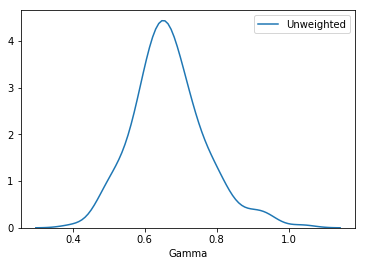

In [17]:
sns.distplot(unweighted_image_gammas, hist=False, label='Unweighted')
# sns.distplot(weighted_d_image_gammas, hist=False, label='Weighted Dark')
# sns.distplot(weighted_b_image_gammas, hist=False, label='Weighted Bright')
plt.xlabel('Gamma')
plt.legend()
plt.show()

In [18]:
print("Unweighted Gammas Mean: {:.2f}".format(np.mean(unweighted_image_gammas)))
print("Unweighted Gammas Std: {:.2f}".format(np.std(unweighted_image_gammas)))
print()

# print("Weighted Dark Gammas Mean: {:.2f}".format(np.mean(weighted_d_image_gammas)))
# print("Weighted Dark Gammas Std: {:.2f}".format(np.std(weighted_d_image_gammas)))
# print()

# print("Weighted Bright Gammas Mean: {:.2f}".format(np.mean(weighted_b_image_gammas)))
# print("Weighted Bright Gammas Std: {:.2f}".format(np.std(weighted_b_image_gammas)))

Unweighted Gammas Mean: 0.67
Unweighted Gammas Std: 0.10



In [32]:
simulation_matrix = [black_levels, [val['blue'] for val in distortions], [val['green'] for val in distortions], \
                              [val['red'] for val in distortions], unweighted_image_gammas]

In [42]:
simulation_mean = np.mean(simulation_matrix, axis=1)
simulation_cov = np.cov(simulation_matrix)

In [62]:
simulation_cov

array([[ 8.68405244e+02,  3.03884877e-01,  9.38552174e-01,
         3.62017748e-01,  2.19097417e-01],
       [ 3.03884877e-01,  5.53287551e-02,  3.85000030e-02,
         2.95625575e-02, -1.10112106e-02],
       [ 9.38552174e-01,  3.85000030e-02,  7.22407858e-02,
         3.30439271e-02, -9.14215982e-03],
       [ 3.62017748e-01,  2.95625575e-02,  3.30439271e-02,
         3.63318728e-02, -8.17525918e-03],
       [ 2.19097417e-01, -1.10112106e-02, -9.14215982e-03,
        -8.17525918e-03,  1.01516465e-02]])

In [45]:
with open('simulation_mean.pkl', 'wb') as f:
    pickle.dump(simulation_mean, f)

In [46]:
with open('simulation_cov.pkl', 'wb') as f:
    pickle.dump(simulation_cov, f)

In [50]:
sim_vars = np.random.multivariate_normal(simulation_mean, simulation_cov)

In [54]:
paths = []
for filename in os.listdir('./Places365/val_large'):
    paths.append(filename)

In [75]:
for idx, path in enumerate(paths[:500]):
    print("Test Image {}".format(idx+1))
    sim_bl = sim_blue = sim_green = sim_red = sim_gamma = -1
    while not (sim_bl>0 and sim_blue>0 and sim_green>0 and sim_red>0 and sim_gamma>0):
        sim_vars = np.random.multivariate_normal(simulation_mean, simulation_cov)

        sim_bl = sim_vars[0]
        sim_blue = sim_vars[1]
        sim_green = sim_vars[2]
        sim_red = sim_vars[3]
        sim_gamma = sim_vars[4]

    print(sim_vars)
    
#     while not (sim_bl>0 and sim_blue>0 and sim_green>0 and sim_red>0 and sim_gamma>0):
#         sim_bl = np.random.normal(81, 10)
#         sim_blue = np.random.normal(0.27, 0.1)
#         sim_green = np.random.normal(0.24, 0.1)
#         sim_red = np.random.normal(0.24, 0.1)
#         sim_gamma = np.random.normal(0.67, 0.1)
#     print(sim_bl, sim_blue, sim_green, sim_red, sim_gamma)
    
    img = cv2.imread('./Places365/val_large/'+path)
    
    cv2.imwrite('./Places365/results1/ex_'+str(idx+1)+'.png', img)

    bl_img = apply_black_level(img, sim_bl)
    cv2.imwrite('./Places365/results1/ex_'+str(idx+1)+'_black.png', bl_img)

    color_img = apply_color_distortion(bl_img, {'blue':sim_blue, 'green':sim_green, 'red':sim_red})
    cv2.imwrite('./Places365/results1/ex_'+str(idx+1)+'_black_color.png', color_img)

    noisy = np.random.poisson(color_img / 255.0 * 10) / 10 * 255
    # noisy = gamma_img + np.uint8(random_noise(gamma_img, mode='poisson'))
    cv2.imwrite('./Places365/results1/ex_'+str(idx+1)+'_black_color_noise.png', noisy)

    gamma_img = noisy**sim_gamma
    cv2.imwrite('./Places365/results1/ex_'+str(idx+1)+'_black_color_noise_gamma.png', gamma_img)

Test Image 1
[60.0617298   0.46519984  0.34069693  0.34201364  0.52494713]
Test Image 2
[94.70297279  0.46686769  0.24515044  0.22618791  0.68125313]
Test Image 3
[25.74230514  0.35113541  0.05083001  0.26213281  0.74137839]
Test Image 4
[77.48655143  0.6129449   0.56076237  0.59761922  0.62692678]
Test Image 5
[54.00213727  0.79080183  0.29692657  0.35953683  0.61907486]
Test Image 6
[54.26173648  0.61259306  0.52014633  0.35216232  0.73493384]
Test Image 7
[88.12682714  0.18004009  0.17391134  0.17722851  0.59181108]
Test Image 8
[140.68891742   0.41987831   0.3341089    0.4182872    0.62887061]
Test Image 9
[100.0357808    0.33554012   0.48067299   0.4311728    0.48353924]
Test Image 10
[74.09231804  0.420447    0.50927925  0.54635049  0.70848855]
Test Image 11
[6.86327508e+01 3.21113059e-02 6.90736910e-02 1.24930580e-01
 6.75022472e-01]
Test Image 12
[111.84404549   0.25405298   0.56377577   0.25878771   0.68419185]
Test Image 13
[62.12770492  0.23615483  0.600655    0.57125078  0.

In [19]:
# for idx in range(20):
#     print("Image Set {}".format(idx+1))

#     IMG_ID = idx

#     cv2.imwrite('./simulation_results/ex_'+str(IMG_ID)+'.png', images['bright'][IMG_ID])

#     bl_img = apply_black_level(images['bright'][IMG_ID], black_levels[IMG_ID])
#     cv2.imwrite('./simulation_results/ex_'+str(IMG_ID)+'_black.png', bl_img)

#     color_img = apply_color_distortion(bl_img, distortions[IMG_ID])
#     cv2.imwrite('./simulation_results/ex_'+str(IMG_ID)+'_black_color.png', color_img)

#     noisy = np.random.poisson(color_img / 255.0 * 10) / 10 * 255
#     # noisy = gamma_img + np.uint8(random_noise(gamma_img, mode='poisson'))
#     cv2.imwrite('./simulation_results/ex_'+str(IMG_ID)+'_black_color_noise.png', noisy)

#     gamma_img = noisy**unweighted_image_gammas[IMG_ID]
#     cv2.imwrite('./simulation_results/ex_'+str(IMG_ID)+'_black_color_noise_gamma.png', gamma_img)


#     cv2.imwrite('./simulation_results/ex_'+str(IMG_ID)+'_dark.png', images['dark'][IMG_ID])

## GAMMAS (METHOD 2 - Optimization)

In [20]:
candidate_gammas = np.linspace(0,1,1000)
image_gammas = []

start_time = time.time()
for img_idx, (bright, dark) in enumerate(zip(images['bright'], images['dark'])):
    print('Image Set {}'.format(img_idx+1), end='\t')
    
    optimal_gamma = -1
    min_diff = sys.maxsize
    
    bright_0 = np.where(bright.flatten()==0)[0]
    bright_255 = np.where(bright.flatten()==255)[0]
    dark_0 = np.where(dark.flatten()==0)[0]
    dark_255 = np.where(dark.flatten()==255)[0]
    bad_indices = list(set().union(bright_0, bright_255, dark_0, dark_255))
    
    filtered_bright = np.delete(bright, bad_indices)  
    filtered_dark = np.delete(dark, bad_indices)
    
    for g_idx, gamma in enumerate(candidate_gammas):
#         clear_output(wait=True)
        
        gamma_bright = filtered_bright**gamma
        if abs(np.average(gamma_bright) - np.average(filtered_dark)) < min_diff:
            optimal_gamma = gamma
            min_diff = abs(np.average(gamma_bright) - np.average(filtered_dark))
    
#         print("Gammas Tested: {}".format(g_idx+1))

    image_gammas.append(optimal_gamma)
    print('Avg Bright: {:.2f}   Avg Dark: {:.2f}   Min Diff: {:.2f}   Gamma: {:.2f}'.\
          format(np.average(filtered_bright), np.average(filtered_dark), min_diff, optimal_gamma))

elapsed_time = time.time() - start_time
print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))

Image Set 1	Avg Bright: 75.71   Avg Dark: 2.27   Min Diff: 0.00   Gamma: 0.21
Image Set 2	Avg Bright: 123.50   Avg Dark: 1.08   Min Diff: 0.00   Gamma: 0.02
Image Set 3	

KeyboardInterrupt: 

In [ ]:
np.mean(image_gammas)

In [ ]:
def get_average(dark, bright):
    bright_0 = np.where(bright.flatten()<5)[0]
    bright_255 = np.where(bright.flatten()==255)[0]
    dark_0 = np.where(dark.flatten()<5)[0]
    dark_255 = np.where(dark.flatten()==255)[0]
    bad_indices = list(set().union(bright_0, bright_255, dark_0, dark_255))
    
    filtered_bright = np.delete(bright.flatten(), bad_indices)
    filtered_dark = np.delete(dark.flatten(), bad_indices)
    
    ratio_array = np.divide(filtered_dark, filtered_bright, out=np.zeros_like(filtered_dark, dtype=np.float32), where=filtered_bright!=0)
    avg = np.average(ratio_array)
    
    return avg